In [1]:
import h5py
import time
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from simarUtils import *

In [2]:
T_cam_base = EXTRINSICS["humanoidFeb29R"]

#Internal realsense numbers
intrinsics = WIDE_LENS_ROBOT_LEFT_K


In [3]:
T_cam_base, intrinsics

(array([[ 0.01742509, -0.67120392,  0.74106792,  0.09484187],
        [ 0.99969314, -0.00135605, -0.02473448, -0.27895615],
        [ 0.0176068 ,  0.74127152,  0.67097432, -0.16654236],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[266.50860444,   0.        , 320.55882026,   0.        ],
        [  0.        , 266.5005148 , 244.11486376,   0.        ],
        [  0.        ,   0.        ,   1.        ,   0.        ]]))

## Hand Data

In [4]:
h5py_file = h5py.File("/coc/flash7/datasets/v1_datasetMimicplay.hdf5", "r")
nested_ds_print(h5py_file)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/coc/flash7/datasets/v1_datasetMimicplay.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
def scatter_3d(points, angle=0):
    """
        make a 3d scatter plot for points of shape (Time, 3) where 3 is x,y,z
        color the points by time, make the axis interactive
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:,0], points[:,1], points[:,2], c=range(points.shape[0]))
    #rotate the 3d plot
    ax.view_init(15, angle)
    # plt.show()


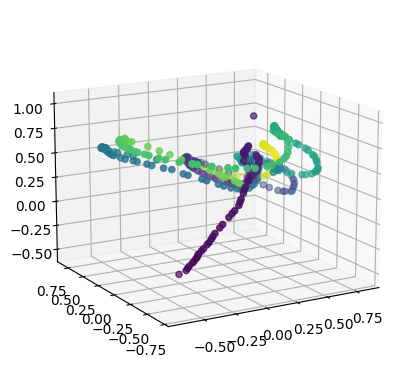

In [ ]:
h5py_file["data/demo_0/obs/ee_pose"].shape
scatter_3d(h5py_file["data/demo_0/obs/ee_pose"][0:500, :3], -120)

In [ ]:
h5py_file["data/demo_0/obs/ee_pose"][100:110][:]

array([[0.25087689, 0.63876992, 0.3117824 ],
       [0.24759885, 0.64367258, 0.31197703],
       [0.23768477, 0.65044251, 0.31343881],
       [0.23626664, 0.65154879, 0.31593795],
       [0.23513838, 0.65129797, 0.31912014],
       [0.23558765, 0.64312435, 0.32449542],
       [0.23891805, 0.63444794, 0.32655544],
       [0.25876513, 0.58324082, 0.32659283],
       [0.27036041, 0.54111614, 0.31844871],
       [0.32412908, 0.42706176, 0.29315451]])

In [ ]:
h5py_file["data/demo_0/actions"][100][:]

array([ 0.59811054,  0.03543127,  0.14237831,  0.77236677,  0.44158757,
        0.2631618 ,  0.68736354,  0.57589399,  0.2780353 ,  0.69624505,
        0.56116187,  0.28456462,  0.1453656 , -0.25412078,  0.32879276,
       -0.58054082,  0.07200848,  0.63641445, -0.6727051 ,  0.39087192,
        0.68561201, -0.6352771 ,  0.38843134,  0.67597828,  0.59799207,
        0.05013302,  0.39880089,  0.61521896,  0.56401076,  0.35426388])

In [ ]:
def project_3d_to_2d(x, y, z):
    # focal_length_x, focal_length_y, principal_point_x, principal_point_y
    camera_intrinsics = (616.16, 615.714, 313.42, 236.67)
    focal_length_x, focal_length_y, principal_point_x, principal_point_y = camera_intrinsics

    # Apply camera intrinsics to project 3D point to 2D
    u = (focal_length_x * x / z) + principal_point_x
    v = (focal_length_y * y / z) + principal_point_y

    return u, v

[ 17.771406 122.093536 427.196381]
Pixel value (339.0523087178962, 412.642229092231)


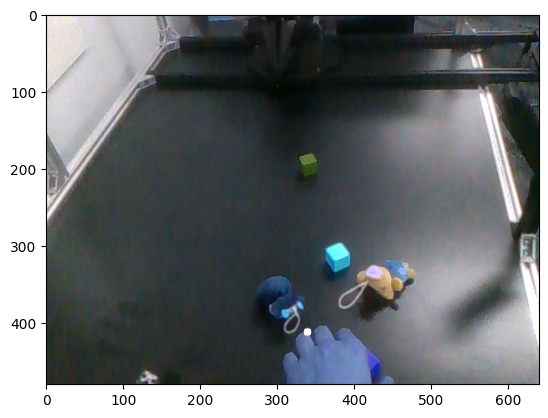

In [ ]:
T = 100
hand_loc = h5py_file["data/demo_0/obs/ee_pose_unnorm"][T][0:3]
print(hand_loc)
px_val = project_3d_to_2d(hand_loc[0], hand_loc[1], hand_loc[2])
# px_val = cam_frame_to_cam_pixels(hand_loc, intrinsics)
print("Pixel value", px_val)
frame = draw_dot_on_frame(h5py_file["data/demo_0/obs/front_image_1"][T], px_val, show=True)


In [ ]:
# Robot frame is x (forward pos), y(left pos), z (up pos)

video = torch.zeros(h5py_file["data/demo_0/obs/front_image_1"][:400].shape)
for t in range(400):
    # hand_loc = h5py_file["demo_0/obs/ee_pose"][t][0, 0:3]
    hand_loc = h5py_file["data/demo_0/obs/ee_pose_unnorm"][t][0:3]
    # print(hand_loc)
    # px_val = cam_frame_to_cam_pixels(hand_loc, intrinsics)
    px_val = project_3d_to_2d(hand_loc[0], hand_loc[1], hand_loc[2])
    # print("Pixel value", px_val)
    frame = draw_dot_on_frame(h5py_file["data/demo_0/obs/front_image_1"][t], px_val, show=False)
    video[t] = torch.from_numpy(frame)
torchvision.io.write_video("hand_traj.mp4", video, fps=30)

[-91.167618  13.367264 155.983826]
Pixel value (-46.706052472132626, 289.4345192296796)
[-87.11898    1.692047 175.914917]
Pixel value (8.276856756496727, 242.59227790755233)
[-85.787354   0.189011 184.086578]
Pixel value (26.279369678543333, 237.3021847041667)
[-84.575462  -1.690506 191.314972]
Pixel value (41.0314037435607, 231.22940013265662)
[-81.763176  -5.38826  203.658661]
Pixel value (66.04923620930614, 220.37986482308256)
[-80.613861  -7.417694 209.589645]
Pixel value (76.42815532294071, 214.87895186154827)
[-79.805145 -11.247711 221.592468]
Pixel value (91.51381976286308, 205.41725394252114)
[-79.678963 -13.758972 227.136108]
Pixel value (97.27211283940821, 199.37257617512753)
[-80.461876 -16.74884  237.264114]
Pixel value (104.46556234677783, 193.20579844881217)
[-80.905907 -19.650848 243.702789]
Pixel value (108.8635242137504, 187.02222093633077)
[-81.139793 -26.493973 259.204468]
Pixel value (120.54101438436629, 173.73624651345898)
[-80.874207 -30.725555 268.136658]
Pixel 

In [ ]:
video.shape

torch.Size([400, 480, 640, 3])

In [ ]:
video.shape

torch.Size([400, 480, 640, 3])

## Robot Data

## Calibration Data

In [4]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as Rot
import json
from simarUtils import *
import torchvision

In [5]:
# not processed
# calib = h5py.File("/coc/flash7/datasets/egoplay/aloha/stacking.hdf5")
# demo = calib["data/demo1"]

In [121]:
# demo = h5py.File("/coc/flash7/datasets/egoplay/humanoid_stacking_rand/robomimic/humanoid_stacking_randMimicplay.hdf5", "r+")
data = h5py.File("/coc/flash7/datasets/egoplay/bowl_place_hand_mar1/bowl_place_handMimicplay.hdf5", "r")
# demo = h5py.File("/coc/flash7/datasets/egoplay/bowl_place_hand_mar1/bowl_place_handMimicplay.hdf5", "r")["data/demo_0"]
# demo=demo["data/demo_0"]

In [122]:
nds(data)

dict with keys:  <KeysViewHDF5 ['data', 'mask']>
data: dict with keys:  <KeysViewHDF5 ['demo_0', 'demo_1', 'demo_10', 'demo_11', 'demo_12', 'demo_13', 'demo_14', 'demo_15', 'demo_16', 'demo_17', 'demo_18', 'demo_19', 'demo_2', 'demo_20', 'demo_21', 'demo_22', 'demo_23', 'demo_24', 'demo_25', 'demo_26', 'demo_27', 'demo_28', 'demo_29', 'demo_3', 'demo_30', 'demo_31', 'demo_32', 'demo_33', 'demo_34', 'demo_35', 'demo_36', 'demo_37', 'demo_38', 'demo_39', 'demo_4', 'demo_40', 'demo_41', 'demo_42', 'demo_43', 'demo_44', 'demo_45', 'demo_46', 'demo_47', 'demo_48', 'demo_49', 'demo_5', 'demo_50', 'demo_51', 'demo_52', 'demo_53', 'demo_54', 'demo_55', 'demo_56', 'demo_57', 'demo_58', 'demo_59', 'demo_6', 'demo_60', 'demo_7', 'demo_8', 'demo_9']>
	demo_0: dict with keys:  <KeysViewHDF5 ['actions', 'obs']>
		actions: (655, 30)
		obs: dict with keys:  <KeysViewHDF5 ['Gripper_position', 'ee_pose', 'ee_pose_full_unnorm', 'front_img_1', 'front_img_2', 'wrist_cam_1']>
			Gripper_position: ()
			ee_p

In [123]:
data["mask/valid"][:]

array([b'demo_16', b'demo_19', b'demo_2', b'demo_24', b'demo_3',
       b'demo_31', b'demo_41', b'demo_47', b'demo_54', b'demo_55',
       b'demo_6', b'demo_8'], dtype='|S7')

## Visualize normalized Cam Frame EE pose / Actions

[[-0.02   0.02   0.695]
 [-0.019  0.02   0.698]
 [-0.018  0.019  0.701]
 [-0.016  0.019  0.704]
 [-0.015  0.018  0.706]]


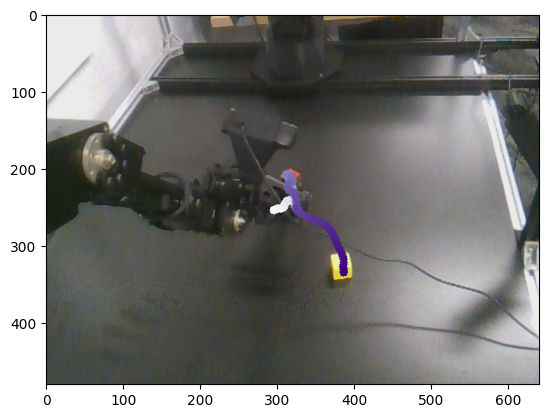

In [ ]:
T = 100
# point = demo["obs/ee_pose"][T][:3][None, :]
points = demo["obs/ee_pose"][T:T+150][:, :3]
mins = meta["obs_mins"]
maxs = meta["obs_maxs"]
points[:, 0] = general_unnorm(points[:, 0], mins[0], maxs[0], -1, 1)
points[:, 1] = general_unnorm(points[:, 1], mins[1], maxs[1], -1, 1)
points[:, 2] = general_unnorm(points[:, 2], mins[2], maxs[2], -1, 1)
print(points.round(3)[:5])
px_val = cam_frame_to_cam_pixels(points, intrinsics)
plt.imshow(draw_dot_on_frame(demo["obs/front_img_1"][T], px_val, show=False))

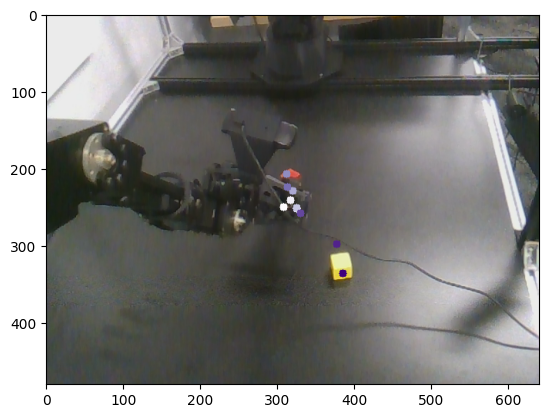

In [ ]:
T = 100
# point = demo["obs/ee_pose"][T][:3][None, :]
points = demo["actions"][T].reshape(-1, 3)
mins = meta["obs_mins"]
maxs = meta["obs_maxs"]
points[:, 0] = general_unnorm(points[:, 0], mins[0], maxs[0], -1, 1)
points[:, 1] = general_unnorm(points[:, 1], mins[1], maxs[1], -1, 1)
points[:, 2] = general_unnorm(points[:, 2], mins[2], maxs[2], -1, 1)

px_val = cam_frame_to_cam_pixels(points, intrinsics)
plt.imshow(draw_dot_on_frame(demo["obs/front_img_1"][T], px_val, show=False))

## Visualize Unnormalized Cam Frame EE_pose

(40, 3)
px val:  (40, 3)


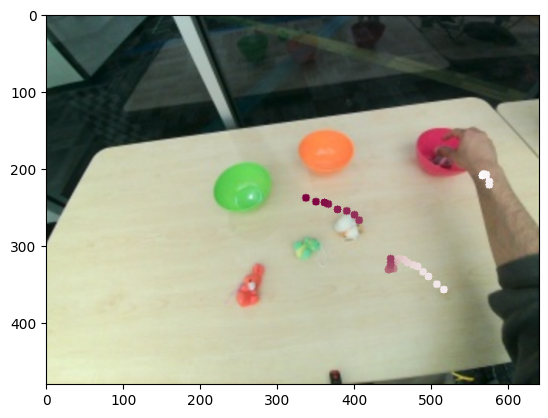

In [124]:
demo=data["data/demo_0"]
T = 2
# point = demo["obs/ee_pose"][T][:3][None, :]
points = demo["obs/ee_pose"][T:T+40][:, :3]
# points = demo["actions"][T].reshape(-1, 3)
print(points.shape)
px_val = cam_frame_to_cam_pixels(points, intrinsics)
print("px val: ", px_val.shape)
plt.imshow(cv2.cvtColor(draw_dot_on_frame(demo["obs/front_img_1"][T], px_val, show=False), cv2.COLOR_BGR2RGB))

In [126]:
demo=data["data/demo_19"]
imgs_tensor=torch.Tensor(*demo["obs/front_img_1"].shape)

for i in range(len(demo["obs/front_img_1"])):
    # inverted robot: (x forward, y right, z down) right handed frame
    # point = demo["obs/ee_pose"][T][:3][None, :]
    # points = demo["obs/ee_pose"][i:i+40][:, :3]
    points = demo["actions"][i].reshape(-1, 3)
    px_val = cam_frame_to_cam_pixels(points, intrinsics)
    imgs_tensor[i]=torch.Tensor(cv2.cvtColor(draw_dot_on_frame(demo["obs/front_img_1"][i], px_val, show=False), cv2.COLOR_BGR2RGB))
torchvision.io.write_video("viz19.mp4",imgs_tensor,fps=30)

## Unnormalized Robot Frame EE_Pose

In [8]:
T_cam_base

array([[ 0.07 , -0.911,  0.407,  0.035],
       [ 0.997,  0.048, -0.063, -0.309],
       [ 0.038,  0.41 ,  0.911, -0.195],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

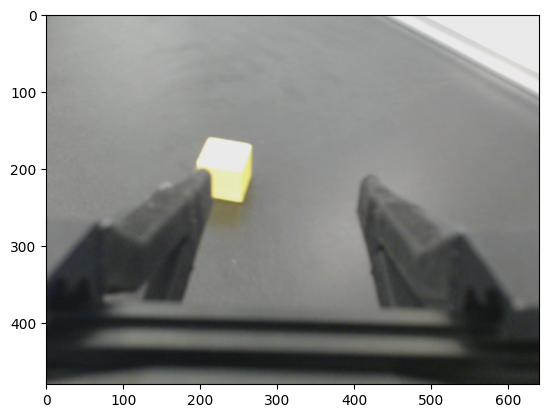

In [9]:
plt.imshow(demo["obs/wrist_img_1"][100])

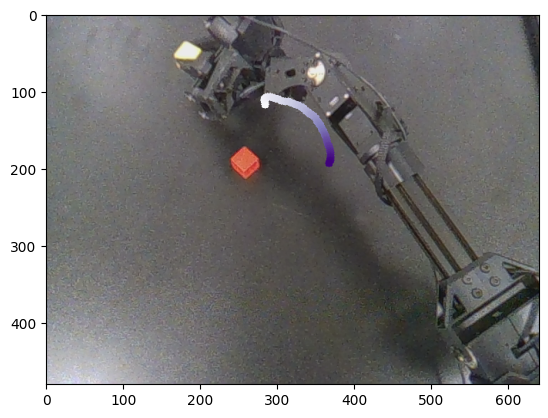

In [12]:
T = 250
# inverted robot: (x forward, y right, z down) right handed frame
# point = demo["obs/ee_pose"][T][:3][None, :]
points = demo["obs/ee_pose"][T:T+50][:, :3]
px_val = ee_pose_to_cam_pixels(points, T_cam_base, intrinsics)
plt.imshow(draw_dot_on_frame(demo["obs/front_img_1"][T], px_val, show=False))

In [25]:
imgs_tensor=torch.Tensor(*demo["obs/front_img_1"].shape)

for i in range(len(demo["obs/front_img_1"])):
    # inverted robot: (x forward, y right, z down) right handed frame
    # point = demo["obs/ee_pose"][T][:3][None, :]
    points = demo["obs/ee_pose"][i:i+50][:, :3]
    px_val = ee_pose_to_cam_pixels(points, T_cam_base, intrinsics)
    imgs_tensor[i]=torch.Tensor(draw_dot_on_frame(demo["obs/front_img_1"][i], px_val, show=False))
torchvision.io.write_video("viz.mp4",imgs_tensor,fps=30)

3d pos in base frame:  [ 0.37 -0.14 -0.02  1.  ]
3d pos in cam frame:  [0.07256679 0.18038024 0.61396421 1.        ]
2d pos cam frame:  [386.20740315 417.59020348   1.        ]
[386.20740315 417.59020348   1.        ]


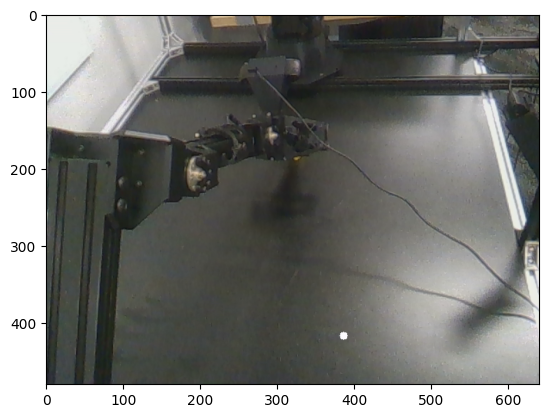

array([[[235, 236, 232],
        [235, 236, 232],
        [235, 236, 232],
        ...,
        [ 69,  69,  61],
        [ 67,  67,  59],
        [ 71,  71,  63]],

       [[235, 236, 232],
        [235, 236, 232],
        [235, 236, 232],
        ...,
        [ 69,  71,  62],
        [ 67,  69,  60],
        [ 69,  71,  62]],

       [[235, 236, 232],
        [235, 236, 232],
        [235, 236, 232],
        ...,
        [ 68,  72,  63],
        [ 69,  71,  62],
        [ 69,  71,  62]],

       ...,

       [[ 24,  27,  37],
        [ 37,  40,  50],
        [ 42,  41,  48],
        ...,
        [154, 157, 158],
        [157, 157, 159],
        [160, 160, 162]],

       [[ 31,  34,  44],
        [ 38,  41,  51],
        [ 40,  41,  50],
        ...,
        [154, 157, 158],
        [155, 158, 159],
        [157, 160, 161]],

       [[ 34,  38,  48],
        [ 38,  42,  52],
        [ 42,  43,  52],
        ...,
        [153, 156, 157],
        [155, 157, 161],
        [156, 158, 162]]

In [ ]:
T = 500
px_val = ee_pose_to_cam_pixels(np.array([0.37, -0.14, -0.02]), T_cam_base, intrinsics)
print(px_val)
draw_dot_on_frame(demo["obs/front_img_1"][T], [px_val])

## Raw Aloha Data

In [4]:
from modern_robotics import FKinSpace

In [14]:
demo = h5py.File("/coc/flash7/datasets/egoplay/bowl_place_robot_mar4/rawAloha/episode_5.hdf5", "r+")
nds(demo)

dict with keys:  <KeysViewHDF5 ['action', 'observations']>
action: (600, 14)
observations: dict with keys:  <KeysViewHDF5 ['effort', 'images', 'qpos', 'qvel']>
	effort: (600, 14)
	images: dict with keys:  <KeysViewHDF5 ['cam_high', 'cam_right_wrist', 'cam_right_wrist_depth']>
		cam_high: (600, 480, 640, 3)
		cam_right_wrist: (600, 480, 640, 3)
		cam_right_wrist_depth: (600, 480, 640)
	qpos: (600, 14)
	qvel: (600, 14)


[-0.36968938 -0.7838642   0.91732055  0.31753403 -0.17794177 -0.41877678]
[[ 0.91045057  0.41348614  0.01043898  0.28017013]
 [-0.41207429  0.9045855   0.10917811 -0.11905493]
 [ 0.03570068 -0.10370291  0.99396739  0.34794961]
 [ 0.          0.          0.          1.        ]]
[-0.36968938 -0.7838642   0.91885453  0.31753403 -0.17947575 -0.41877678]
[[ 0.91025826  0.41390563  0.0105849   0.28007868]
 [-0.41250524  0.90438581  0.10920498 -0.11910893]
 [ 0.03562772 -0.10377106  0.99396289  0.34748065]
 [ 0.          0.          0.          1.        ]]
[-0.36968938 -0.7838642   0.91885453  0.31753403 -0.18100974 -0.41877678]
[[ 0.91001383  0.41447336  0.00930941  0.28003543]
 [-0.41291585  0.90412837  0.10978336 -0.11918158]
 [ 0.03708538 -0.10374838  0.99391194  0.34773857]
 [ 0.          0.          0.          1.        ]]
[-0.36968938 -0.7823302   0.9203885   0.319068   -0.18561168 -0.41877678]
[[ 0.90927341  0.4161261   0.00780548  0.28015183]
 [-0.41443242  0.9035278   0.10901045 

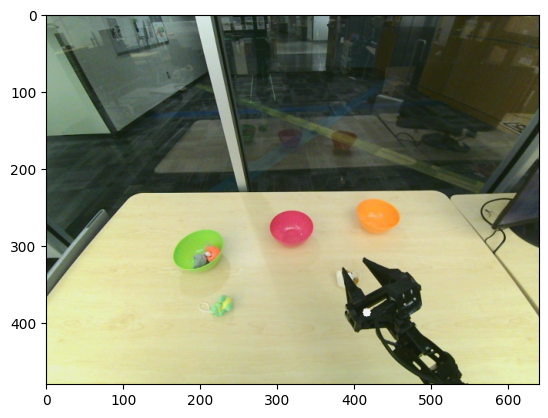

In [15]:
T = 537
# inverted robot: (x forward, y right, z down) right handed frame
# point = demo["obs/ee_pose"][T][:3][None, :]
rollout = 5
joint_positions = demo["action"][T:T+rollout][:, 7:13]
points = np.zeros((rollout, 3))
for i in range(rollout):
    M = np.array([[1.0, 0.0, 0.0, 0.536494],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.42705],
                [0.0, 0.0, 0.0, 1.0]])

    Slist = np.array([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                      [0.0, 1.0, 0.0, -0.12705, 0.0, 0.0],
                      [0.0, 1.0, 0.0, -0.42705, 0.0, 0.05955],
                      [1.0, 0.0, 0.0, 0.0, 0.42705, 0.0],
                      [0.0, 1.0, 0.0, -0.42705, 0.0, 0.35955],
                      [1.0, 0.0, 0.0, 0.0, 0.42705, 0.0]]).T
    print(joint_positions[i])
    T_obs = FKinSpace(M, Slist, joint_positions[i])
    print(T_obs)
    points[i] = T_obs[:3, 3]
px_val = ee_pose_to_cam_pixels(points, EXTRINSICS["humanoidFeb29R"], intrinsics)
plt.imshow(draw_dot_on_frame(demo["observations/images/cam_high"][T], px_val, show=False, palette="Pastel1"))

# IK ground up

In [ ]:
import h5py
import matplotlib.pyplot as plt

In [ ]:
file = h5py.File("/coc/flash7/skareer6/episode_0.hdf5", "r+")
file["observations/qpos"].shape
joint_poses = file["observations/qpos"][0:700]

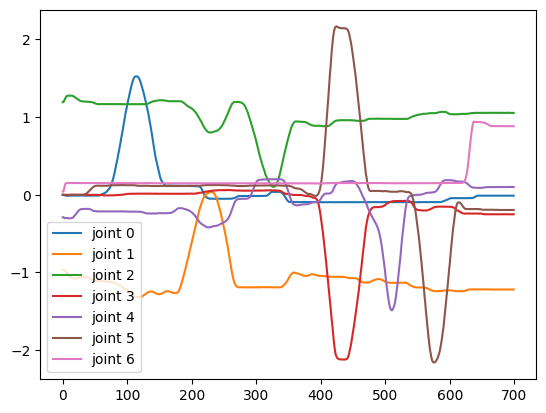

In [ ]:
# plt.plot(joint_poses)
#plot each joint in joint_poses and label it in the legend
joint_poses = joint_poses[:, 0:7]
for i in range(joint_poses.shape[1]):
    plt.plot(joint_poses[:,i], label="joint {}".format(i))
plt.legend()
plt.show()

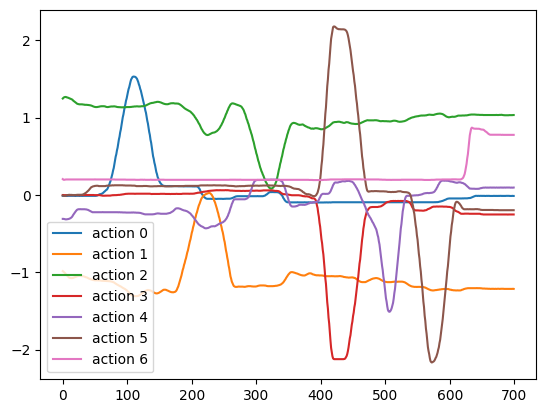

In [ ]:
# plot same for actions
actions = file["action"][:, :7]
for i in range(actions.shape[1]):
    plt.plot(actions[:,i], label="action {}".format(i))
plt.legend()
plt.show()

## Next check the poses for 2 known positions

In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from modern_robotics import FKinSpace

In [ ]:
file = h5py.File("/coc/flash7/skareer6/touch_points.hdf5", "r+")

In [ ]:
M = np.array([[1.0, 0.0, 0.0, 0.536494],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.42705],
    [0.0, 0.0, 0.0, 1.0]])

Slist = np.array([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, -0.12705, 0.0, 0.0],
    [0.0, 1.0, 0.0, -0.42705, 0.0, 0.05955],
    [1.0, 0.0, 0.0, 0.0, 0.42705, 0.0],
    [0.0, 1.0, 0.0, -0.42705, 0.0, 0.35955],
    [1.0, 0.0, 0.0, 0.0, 0.42705, 0.0]]).T

In [ ]:
joint_poses = file["observations/qpos"][0:700]

[[ 0.72 -0.12  0.69  0.34]
 [ 0.13  0.99  0.04  0.09]
 [-0.68  0.06  0.73  0.03]
 [ 0.    0.    0.    1.  ]]


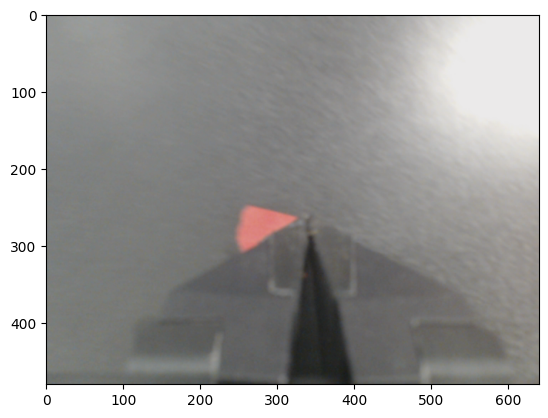

In [ ]:
T = 200
# print joint pos and show camera image
joint_poses = joint_poses[:, 0:7]
# print(joint_poses[T])
plt.imshow(file["observations/images/cam_left_wrist"][T])
trans = FKinSpace(M, Slist, joint_poses[T][:6])
print(trans.round(2))